# ANALYSIS OF DEMAND FOR HEALTH SERVICES WITH DIFFERENTIAL APPROACHANALYSIS OF DEMAND FOR HEALTH SERVICES WITH DIFFERENTIAL APPROACH
### Team 61

This notebook shows the experimentation process for building the classification models associated to risk factors for diseases.

The most important libraries used are:
- Statsmodel
- XGBoost
- SHAP

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression

import xgboost
from xgboost import plot_tree
import shap

In [3]:
%matplotlib inline

In [4]:
pd.set_option( 'display.max_columns', None )

In [157]:
shap.initjs()

## Load model data

In [6]:
clean_data_df = pd.read_csv( './data/bdModelos.txt', sep = '|' )

In [7]:
clean_data_df[ 'DepartamentoOcurrencia' ] = clean_data_df[ 'DepartamentoOcurrencia' ].str.strip()

In [8]:
clean_data_df[ 'DepartamentoOcurrencia' ].replace( { '1': np.nan }, inplace = True )

In [9]:
clean_data_df[ 'DepartamentoOcurrencia' ].value_counts( dropna = False, normalize = True )

Antioquia                                                   0.161124
Bolívar                                                     0.088753
Nariño                                                      0.080349
Magdalena                                                   0.060900
Cauca                                                       0.056465
Valle del Cauca                                             0.055211
Córdoba                                                     0.053447
Cesar                                                       0.046864
Chocó                                                       0.038401
Caquetá                                                     0.037696
Putumayo                                                    0.034595
Norte de Santander                                          0.030424
Tolima                                                      0.029755
Sucre                                                       0.027552
Meta                              

In [10]:
regiones = {
    'Andina': [ 'Antioquia', 'Bogotá, D.C.', 'Boyacá', 'Caldas', 'Cundinamarca', 'Huila', 'Norte de Santander', 'Quindio', 'Risaralda', 'Santander', 'Tolima' ],
    'Caribe': [ 'Atlántico', 'Bolívar', 'Cesar', 'Córdoba', 'La Guajira', 'Magdalena', 'Archipiélago de San Andrés, Providencia y Santa Catalina', 'Sucre' ],
    'Amazonía': [ 'Amazonas', 'Caquetá', 'Guainía', 'Guaviare', 'Putumayo', 'Vaupés' ],
    'Pacífica': [ 'Cauca', 'Chocó', 'Nariño', 'Valle del Cauca' ],
    'Orinoquía': [ 'Arauca', 'Casanare', 'Meta', 'Vichada' ]
}

In [11]:
def assign_region( x ):
    try:
        for region in regiones.keys():
            if x in regiones[ region ]:
                return region
        return None
    except TypeError:
        return None

clean_data_df[ 'Region' ] = clean_data_df[ 'DepartamentoOcurrencia' ].apply( assign_region )

In [12]:
clean_data_df = clean_data_df.loc[ clean_data_df[ 'Region' ].notnull() ]

In [13]:
clean_data_df.shape

(517510, 31)

In [14]:
clean_data_df[ 'Region' ].value_counts( dropna = False, normalize = True )

Caribe       0.309561
Andina       0.308697
Pacífica     0.234297
Amazonía     0.088093
Orinoquía    0.059352
Name: Region, dtype: float64

In [15]:
clean_data_df = clean_data_df.loc[ ~clean_data_df[ 'Sexo' ].isin( [ 'No Reportado', 'No Definido' ] ) ]

In [16]:
clean_data_df.shape

(503643, 31)

In [17]:
clean_data_df[ 'Sexo' ].value_counts( dropna = False, normalize = True )

Femenino     0.596508
Masculino    0.403492
Name: Sexo, dtype: float64

In [18]:
clean_data_df[ 'Etnia' ].value_counts( dropna = False, normalize = True )

No aplica       0.927788
NARP            0.037711
Indígena        0.033395
Rom (Gitano)    0.001106
Name: Etnia, dtype: float64

In [19]:
clean_data_df[ 'IndDiscapacidad' ].value_counts( dropna = False, normalize = True )

No    0.961707
Si    0.038293
Name: IndDiscapacidad, dtype: float64

In [20]:
clean_data_df[ 'IndAdultoMayor' ].value_counts( dropna = False, normalize = True )

No     0.891993
Si     0.107374
NaN    0.000633
Name: IndAdultoMayor, dtype: float64

In [21]:
clean_data_df[ 'IndEtnia' ].value_counts( dropna = False, normalize = True )

No    0.927788
Si    0.072212
Name: IndEtnia, dtype: float64

In [22]:
clean_data_df = clean_data_df.loc[ clean_data_df[ 'CicloVida' ].notnull() ]

In [23]:
clean_data_df.shape

(503484, 31)

In [24]:
clean_data_df[ 'CicloVida' ].value_counts( dropna = False, normalize = True )

AdulteMedia        0.310538
AdolesJuventud     0.248181
AdulteTemprana     0.243658
AdultoMayor        0.108426
infancia           0.071595
PrimeraInfancia    0.017601
Name: CicloVida, dtype: float64

In [25]:
clean_data_df.dtypes

PersonaID                                 int64
Cerebro                                   int64
Diabetes                                  int64
Hipertension                              int64
Infarto                                   int64
Mental                                    int64
Tumor                                     int64
Sexo                                     object
Etnia                                    object
IndDiscapacidad                          object
IndAdultoMayor                           object
IndEtnia                                 object
FechaNacimiento                          object
Hecho                                    object
DepartamentoOcurrencia                   object
MuncipioOcurrencia                       object
SujetoDesc                               object
Probable.manera.de.muerte..violenta.     object
probableManeraMuerte                     object
TipoAlteracion                           object
OrigenDiscapacidad                      

In [26]:
clean_data_df.head()

,PersonaID,Cerebro,Diabetes,Hipertension,Infarto,Mental,Tumor,Sexo,Etnia,IndDiscapacidad,IndAdultoMayor,IndEtnia,FechaNacimiento,Hecho,DepartamentoOcurrencia,MuncipioOcurrencia,SujetoDesc,Probable.manera.de.muerte..violenta.,probableManeraMuerte,TipoAlteracion,OrigenDiscapacidad,TipoRegimen,Edad,GrupoEdad,CicloVida,Total,CONSULTAS,HOSPITALIZACIONES,PROCEDIMIENTOS DE SALUD,URGENCIAS,Region
1,175,0,0,0,0,0,0,Femenino,No aplica,No,No,No,1967-03-04,Desplazamiento Forzado,Cauca,Caloto,Sujeto De Atencion y/o Reparacion,NaN,NaN,NaN,NaN,Subsidiado,53.0,"[50,55)",AdulteMedia,0.166667,0.166667,NaN,NaN,NaN,Pacífica
2,573,0,0,0,0,0,0,Masculino,No aplica,No,No,No,1973-12-09,Amenaza,Caquetá,Solita,Sujeto De Atencion y/o Reparacion,NaN,NaN,NaN,NaN,Subsidiado,46.0,"[45,50)",AdulteMedia,1.166667,0.333333,NaN,0.833333,NaN,Amazonía
3,978,0,0,0,0,0,1,Femenino,No aplica,No,No,No,1979-02-28,Desplazamiento Forzado,Chocó,Riosucio,Sujeto De Atencion y/o Reparacion,NaN,NaN,NaN,NaN,Contributivo,41.0,"[40,45)",AdulteMedia,3.500000,1.166667,NaN,2.333333,NaN,Pacífica
4,1510,0,0,1,0,1,0,Femenino,No aplica,No,Si,No,1944-05-02,Homicidio,Casanare,San Luis De Palenque,Sujeto De Atencion y/o Reparacion,NaN,NaN,NaN,NaN,Subsidiado,76.0,"[75,80)",AdultoMayor,18.000000,6.833333,NaN,11.166667,NaN,Orinoquía
5,1525,0,0,0,0,0,0,Femenino,No aplica,No,No,No,1973-02-04,Desplazamiento Forzado,Antioquia,El Bagre,Sujeto De Atencion y/o Reparacion,NaN,NaN,NaN,NaN,Subsidiado,47.0,"[45,50)",AdulteMedia,1.833333,NaN,NaN,1.833333,NaN,Andina


In [27]:
classes_df = pd.concat( [
    clean_data_df[ 'Cerebro' ].value_counts( dropna = False, normalize = True ).reset_index().rename( columns = { 'index': 'class' } ),
    clean_data_df[ 'Diabetes' ].value_counts( dropna = False, normalize = True ).reset_index()[ 'Diabetes' ],
    clean_data_df[ 'Hipertension' ].value_counts( dropna = False, normalize = True ).reset_index()[ 'Hipertension' ],
    clean_data_df[ 'Infarto' ].value_counts( dropna = False, normalize = True ).reset_index()[ 'Infarto' ],
    clean_data_df[ 'Mental' ].value_counts( dropna = False, normalize = True ).reset_index()[ 'Mental' ],
    clean_data_df[ 'Tumor' ].value_counts( dropna = False, normalize = True ).reset_index()[ 'Tumor' ]
], axis = 1 ).set_index( 'class' ).transpose()

classes_df[ 0 ] = classes_df[ 0 ] * 100
classes_df[ 1 ] = classes_df[ 1 ] * 100

In [28]:
classes_df

class,0,1
Cerebro,99.297892,0.702108
Diabetes,95.789141,4.210859
Hipertension,86.740989,13.259011
Infarto,98.848027,1.151973
Mental,93.900700,6.099300
Tumor,97.895663,2.104337


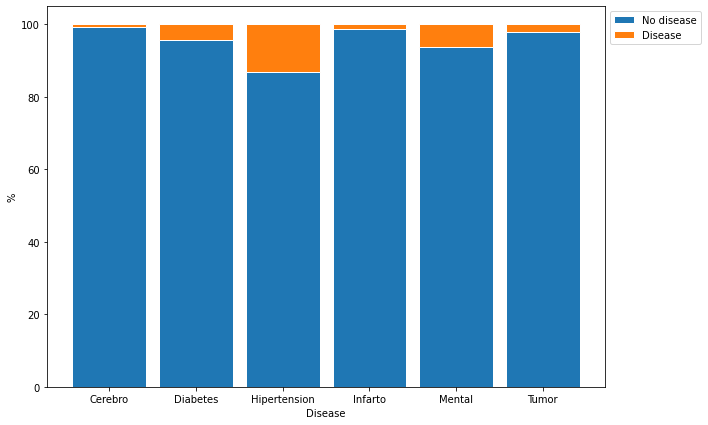

In [29]:
barWidth = 0.85
plt.figure( figsize = ( 10, 7 ) )
plt.bar( classes_df.index, classes_df[ 0 ], edgecolor = 'white', width = barWidth, label = 'No disease' )
plt.bar( classes_df.index, classes_df[ 1 ], bottom = classes_df[ 0 ], edgecolor = 'white', width = barWidth, label = 'Disease' )
plt.xlabel( 'Disease' )
plt.ylabel( '%' )
plt.legend( loc = 'upper left', bbox_to_anchor = ( 1, 1 ), ncol = 1 )
plt.show()

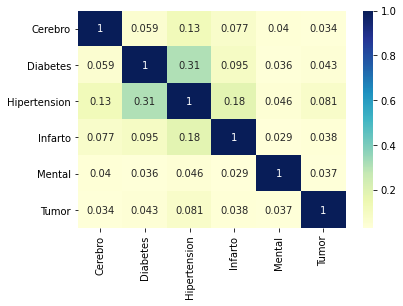

In [30]:
sns.heatmap( clean_data_df[ [ 'Cerebro', 'Diabetes', 'Hipertension', 'Infarto', 'Mental', 'Tumor' ] ].corr(), annot = True, cmap = 'YlGnBu' )

In [31]:
mosaic_df = clean_data_df.copy()

In [32]:
mosaic_df[ 'CicloVida' ].unique()

array(['AdulteMedia', 'AdultoMayor', 'AdulteTemprana', 'AdolesJuventud',
       'infancia', 'PrimeraInfancia'], dtype=object)

In [33]:
mosaic_df[ 'CicloVida' ] = pd.Categorical( mosaic_df[ 'CicloVida' ], [ 'PrimeraInfancia', 'infancia', 'AdolesJuventud', 'AdulteTemprana', 'AdulteMedia', 'AdultoMayor' ] )

In [34]:
mosaic_df.sort_values( 'CicloVida', inplace = True )

In [35]:
mosaic_df[ 'IndEtnia' ].replace( { 'Si': 'Etnia', 'No': 'No Etnia' }, inplace = True )

In [36]:
mosaic_df[ 'IndDiscapacidad' ].replace( { 'Si': 'Disc.', 'No': 'No Disc.' }, inplace = True )

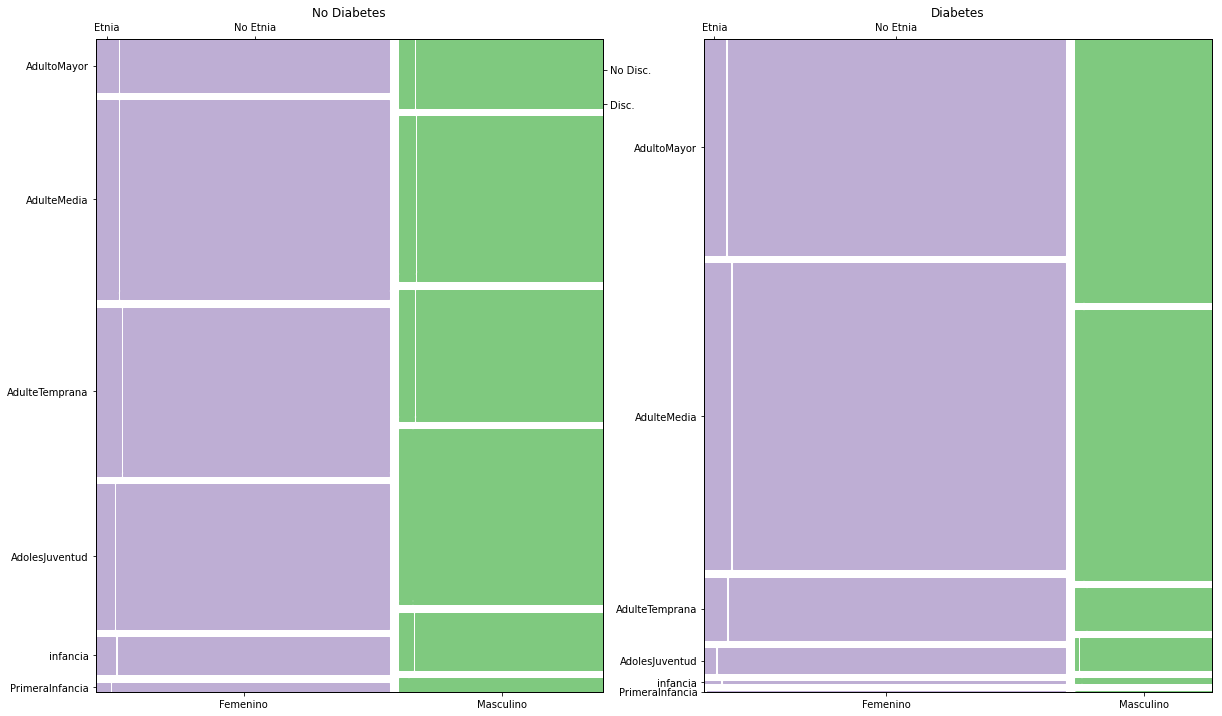

In [39]:
f, axes = plt.subplots( 1, 2, figsize = ( 20, 12 ) )
props = lambda key: { 'color': '#BEAED4' if 'Femenino' in key else '#7FC97F' }
labelizer = lambda k: ''
mosaic( mosaic_df.loc[ mosaic_df[ 'Diabetes' ] == 0 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 0 ] )
mosaic( mosaic_df.loc[ mosaic_df[ 'Diabetes' ] == 1 ], [ 'Sexo', 'CicloVida', 'IndEtnia' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 1 ] )
axes[ 0 ].title.set_text( 'No Diabetes' )
axes[ 1 ].title.set_text( 'Diabetes' )
plt.savefig( './imgs/mosaic-diabetes.png' )

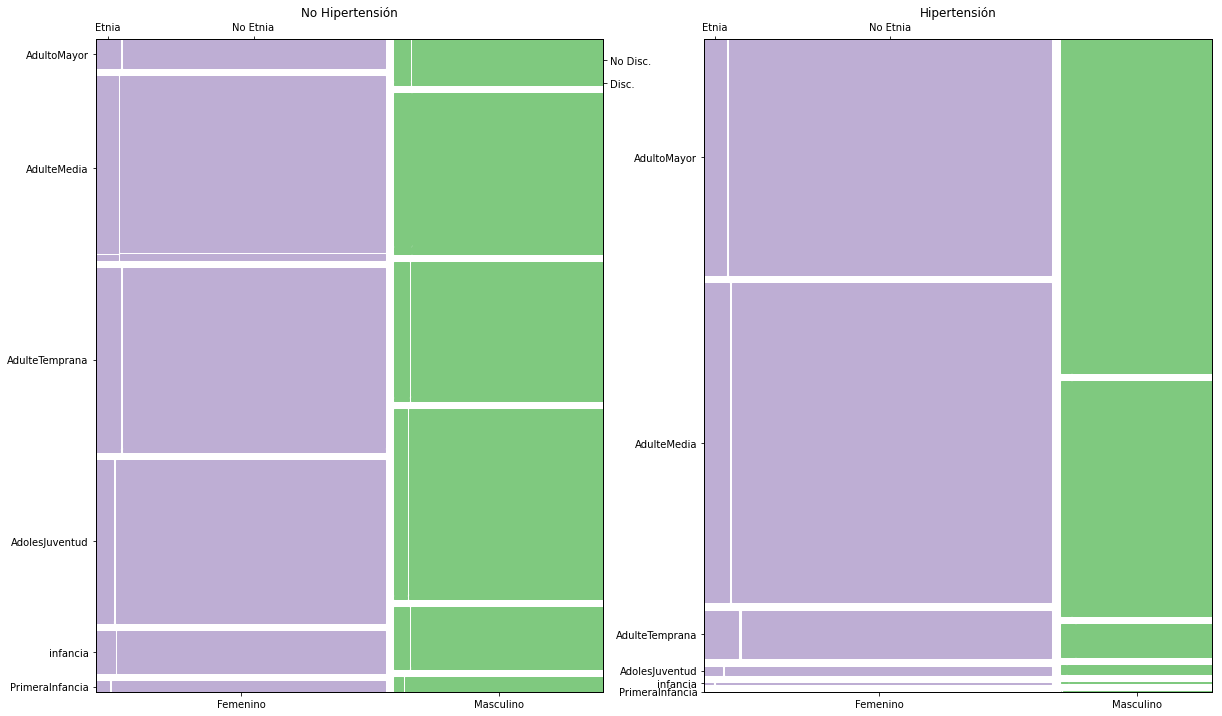

In [40]:
f, axes = plt.subplots( 1, 2, figsize = ( 20, 12 ) )
props = lambda key: { 'color': '#BEAED4' if 'Femenino' in key else '#7FC97F' }
labelizer = lambda k: ''
mosaic( mosaic_df.loc[ mosaic_df[ 'Hipertension' ] == 0 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 0 ] )
mosaic( mosaic_df.loc[ mosaic_df[ 'Hipertension' ] == 1 ], [ 'Sexo', 'CicloVida', 'IndEtnia' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 1 ] )
axes[ 0 ].title.set_text( 'No Hipertensión' )
axes[ 1 ].title.set_text( 'Hipertensión' )
plt.savefig( './imgs/mosaic-hipertension.png' )

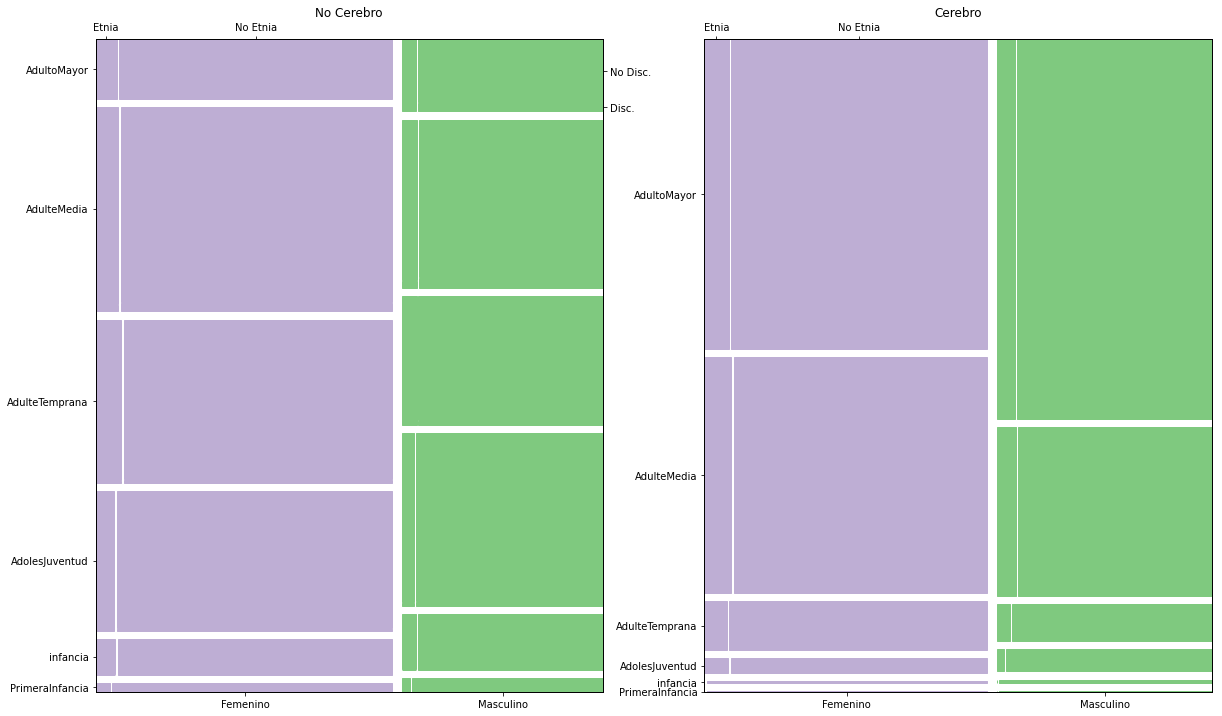

In [41]:
f, axes = plt.subplots( 1, 2, figsize = ( 20, 12 ) )
props = lambda key: { 'color': '#BEAED4' if 'Femenino' in key else '#7FC97F' }
labelizer = lambda k: ''
mosaic( mosaic_df.loc[ mosaic_df[ 'Cerebro' ] == 0 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 0 ] )
mosaic( mosaic_df.loc[ mosaic_df[ 'Cerebro' ] == 1 ], [ 'Sexo', 'CicloVida', 'IndEtnia' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 1 ] )
axes[ 0 ].title.set_text( 'No Cerebro' )
axes[ 1 ].title.set_text( 'Cerebro' )
plt.savefig( './imgs/mosaic-cerebro.png' )

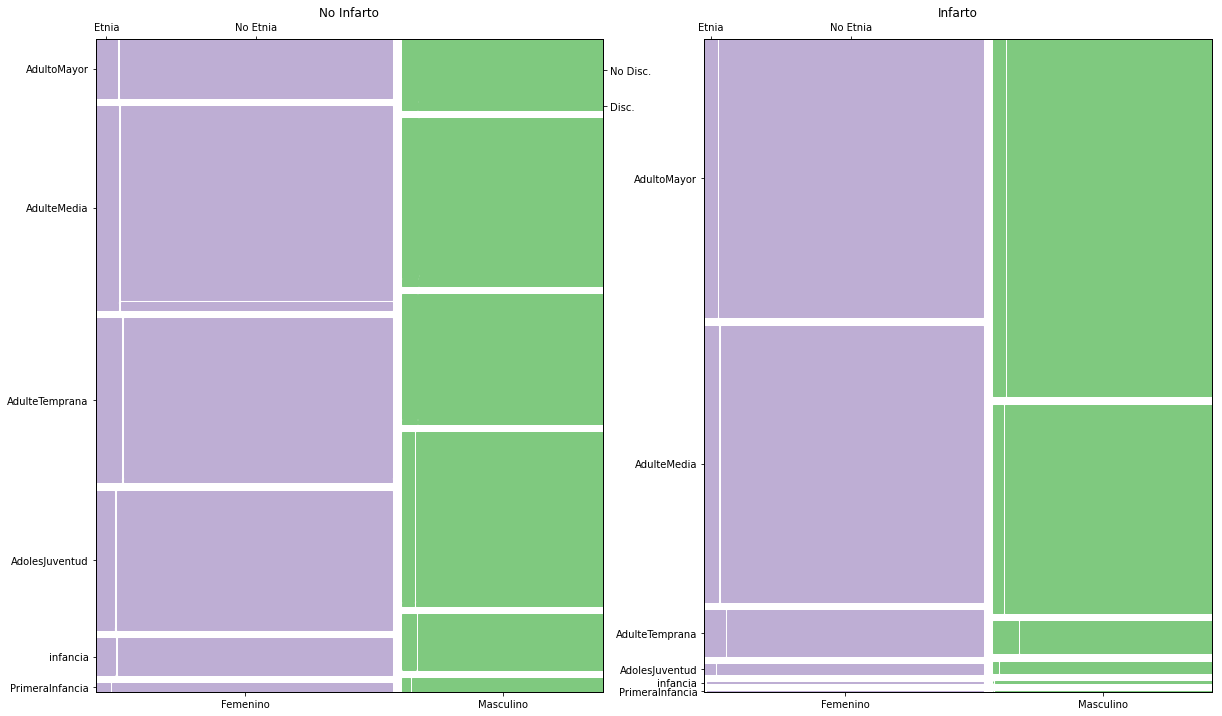

In [42]:
f, axes = plt.subplots( 1, 2, figsize = ( 20, 12 ) )
props = lambda key: { 'color': '#BEAED4' if 'Femenino' in key else '#7FC97F' }
labelizer = lambda k: ''
mosaic( mosaic_df.loc[ mosaic_df[ 'Infarto' ] == 0 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 0 ] )
mosaic( mosaic_df.loc[ mosaic_df[ 'Infarto' ] == 1 ], [ 'Sexo', 'CicloVida', 'IndEtnia' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 1 ] )
axes[ 0 ].title.set_text( 'No Infarto' )
axes[ 1 ].title.set_text( 'Infarto' )
plt.savefig( './imgs/mosaic-infarto.png' )

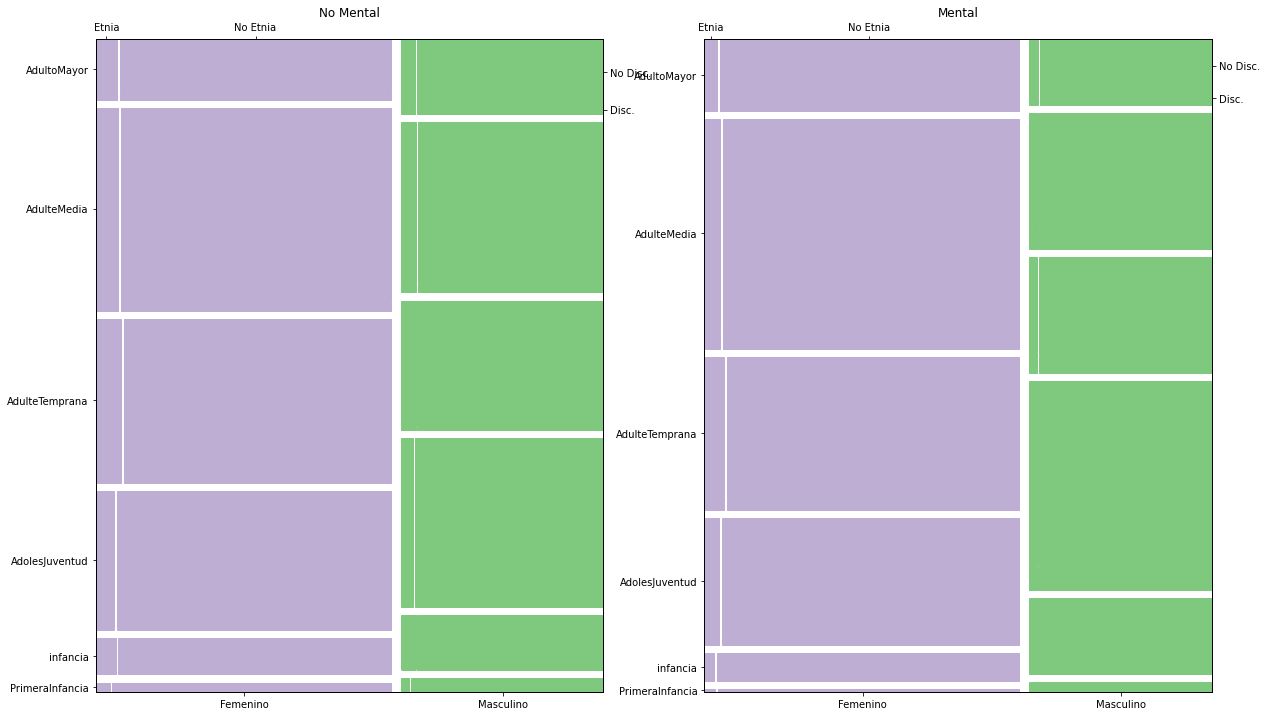

In [43]:
f, axes = plt.subplots( 1, 2, figsize = ( 20, 12 ) )
props = lambda key: { 'color': '#BEAED4' if 'Femenino' in key else '#7FC97F' }
labelizer = lambda k: ''
mosaic( mosaic_df.loc[ mosaic_df[ 'Mental' ] == 0 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 0 ] )
mosaic( mosaic_df.loc[ mosaic_df[ 'Mental' ] == 1 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 1 ] )
axes[ 0 ].title.set_text( 'No Mental' )
axes[ 1 ].title.set_text( 'Mental' )
plt.savefig( './imgs/mosaic-mental.png' )

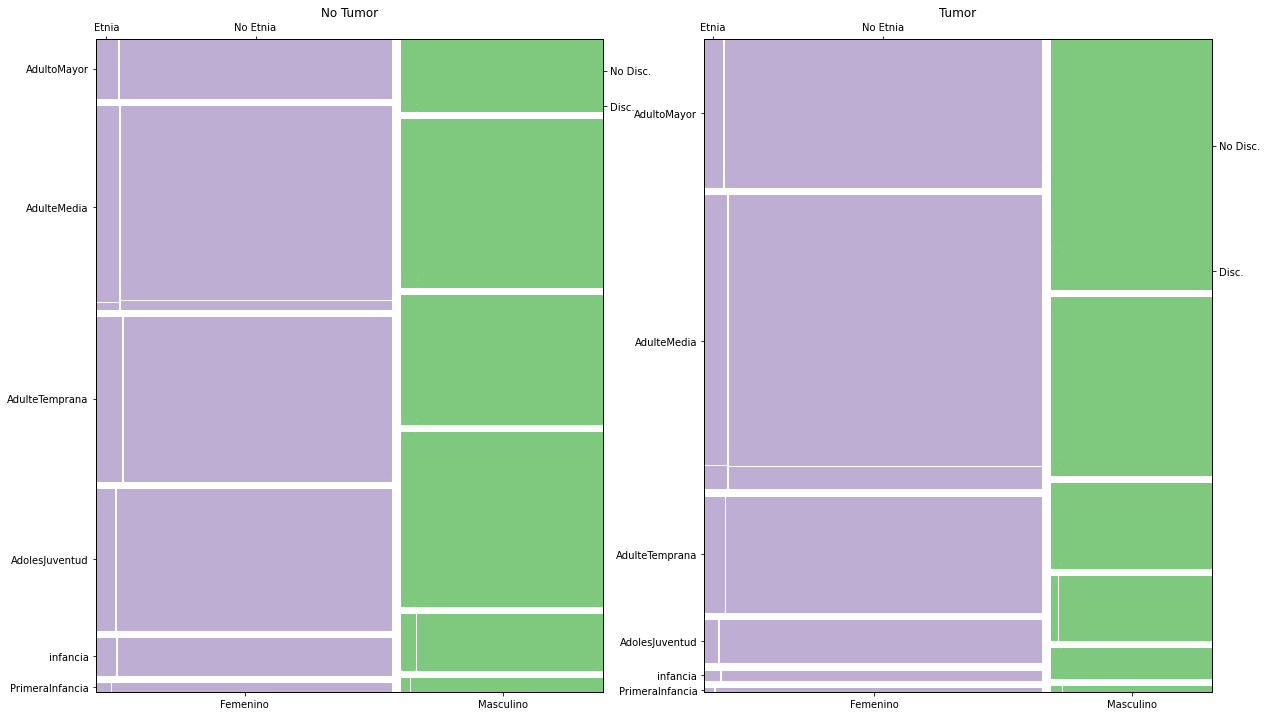

In [44]:
f, axes = plt.subplots( 1, 2, figsize = ( 20, 12 ) )
props = lambda key: { 'color': '#BEAED4' if 'Femenino' in key else '#7FC97F' }
labelizer = lambda k: ''
mosaic( mosaic_df.loc[ mosaic_df[ 'Tumor' ] == 0 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 0 ] )
mosaic( mosaic_df.loc[ mosaic_df[ 'Tumor' ] == 1 ], [ 'Sexo', 'CicloVida', 'IndEtnia', 'IndDiscapacidad' ], properties = props, labelizer = labelizer, gap = 0.02, ax = axes[ 1 ] )
axes[ 0 ].title.set_text( 'No Tumor' )
axes[ 1 ].title.set_text( 'Tumor' )
plt.savefig( './imgs/mosaic-tumor.png' )

# Preparing data for modeling

In [170]:
X = clean_data_df[ [ 'Sexo', 'IndDiscapacidad', 'IndEtnia', 'CicloVida', 'Cerebro', 'Hipertension', 'Diabetes', 'Infarto', 'Mental', 'Tumor' ] ]

In [171]:
X.shape

(503484, 10)

In [172]:
X.isnull().sum()

Sexo               0
IndDiscapacidad    0
IndEtnia           0
CicloVida          0
Cerebro            0
Hipertension       0
Diabetes           0
Infarto            0
Mental             0
Tumor              0
dtype: int64

In [173]:
X = pd.get_dummies( X, drop_first = True )

In [174]:
X.rename( columns = { 'CicloVida_AdultoMayor': 'Elderly', 'CicloVida_AdulteMedia': 'Middle adulthood', 'Hipertension': 'Hypertension', 'Cerebro': 'Cerebrovascular',
                                'IndDiscapacidad_Si': 'Disability', 'CicloVida_AdulteTemprana': 'Early adulthood', 'Infarto': 'Heart attack', 'Tumor': 'Cancer',
                                'IndEtnia_Si': 'Ethnicity', 'Sexo_Masculino': 'Male', 'CicloVida_infancia': 'Childhood', 'CicloVida_PrimeraInfancia': 'Early childhood' }, inplace = True )

In [175]:
X[ 'Intercept' ] = 1

In [176]:
X.isnull().sum()

Cerebrovascular     0
Hypertension        0
Diabetes            0
Heart attack        0
Mental              0
Cancer              0
Male                0
Disability          0
Ethnicity           0
Middle adulthood    0
Early adulthood     0
Elderly             0
Early childhood     0
Childhood           0
Intercept           0
dtype: int64

# Training Logistic Regression

In [51]:
def forward_selected( X, y ):
    remaining = set( X.columns )
    remaining.remove( y )
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            print( 'Training with: {}'.format( selected + [ candidate ] ) )
            score = sm.Logit( X[ y ], X[ selected + [ candidate ] ] ).fit().prsquared
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    print( 'Best model: {}'.format( selected ) )
    model = sm.Logit( X[ y ], X[ selected ] ).fit()
    return model

In [142]:
def plot_odds( model, disease, ax ):
    ci_df = model.conf_int().rename( columns = { 0: '2.5%', 1: '97.5%' } )
    ci_df[ '2.5%' ] = ci_df[ '2.5%' ].apply( lambda x: np.exp( x ) )
    ci_df[ '97.5%' ] = ci_df[ '97.5%' ].apply( lambda x: np.exp( x ) )
    
    odds_df = np.exp( model.params ).to_frame().sort_values( by = 0, ascending = False ).rename( columns = { 0: 'odd' } ).merge( ci_df, left_index = True, right_index = True, how = 'left' )
    odds_df[ 'min' ] = odds_df[ 'odd' ] - odds_df[ '2.5%' ]
    odds_df[ 'max' ] = odds_df[ '97.5%' ] - odds_df[ 'odd' ]
    odds_df.sort_values( by = 'odd', inplace = True )
    
    odds_df.reset_index( inplace = True )
    odds_df[ 'index' ].replace( { 'CicloVida_AdultoMayor': 'Elderly', 'CicloVida_AdulteMedia': 'Middle adulthood', 'Hipertension': 'Hypertension', 'Cerebro': 'Cerebrovascular',
                                'IndDiscapacidad_Si': 'Disability', 'CicloVida_AdulteTemprana': 'Early adulthood', 'Infarto': 'Heart attack', 'Tumor': 'Cancer',
                                'IndEtnia_Si': 'Ethnicity', 'Sexo_Masculino': 'Male', 'CicloVida_infancia': 'Childhood', 'CicloVida_PrimeraInfancia': 'Early childhood' }, inplace = True )
    odds_df.set_index( 'index', inplace = True )
    
    #plt.figure( figsize = ( 7, 6 ) )
    ax.errorbar( odds_df[ 'odd' ], odds_df.index, xerr = odds_df[ [ 'min', 'max' ] ].to_numpy().T, fmt = 'o' )
    ax.axvline( 1.0, alpha = 0.5, color = 'gray', linestyle = '--' )
    ax.set_xlabel( 'Odds ratio (log scale)' )
    ax.title.set_text( 'Odds Ratio for {}. Pseudo R2: {}'.format( disease, np.round( model.prsquared, 4 ) ) )
    ax.set_xscale( 'log' )

### Brain

In [82]:
lr_best_result_brain = forward_selected( X, 'Cerebro' )

Training with: ['CicloVida_PrimeraInfancia']
Optimization terminated successfully.
         Current function value: 0.681000
         Iterations 12
Training with: ['Diabetes']
Optimization terminated successfully.
         Current function value: 0.669688
         Iterations 7
Training with: ['Hipertension']
Optimization terminated successfully.
         Current function value: 0.620899
         Iterations 7
Training with: ['CicloVida_infancia']
Optimization terminated successfully.
         Current function value: 0.643798
         Iterations 12
Training with: ['CicloVida_AdulteTemprana']
Optimization terminated successfully.
         Current function value: 0.527890
         Iterations 10
Training with: ['IndEtnia_Si']
Optimization terminated successfully.
         Current function value: 0.646645
         Iterations 9
Training with: ['IndDiscapacidad_Si']
Optimization terminated successfully.
         Current function value: 0.672719
         Iterations 7
Training with: ['Sexo_Mascu

In [83]:
print( lr_best_result_brain.summary2() )

                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.190     
Dependent Variable:    Cerebro             AIC:                 34141.3726
Date:                  2020-08-02 16:11    BIC:                 34297.1829
No. Observations:      503484              Log-Likelihood:      -17057.   
Df Model:              13                  LL-Null:             -21052.   
Df Residuals:          503470              LLR p-value:         0.0000    
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        12.0000                                            
--------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                 -7.4129   0.1009 -73.4704 0.0000 -7.6107 -7.2152
Hipertension               1.2843   0.0425  30.2503 0.0

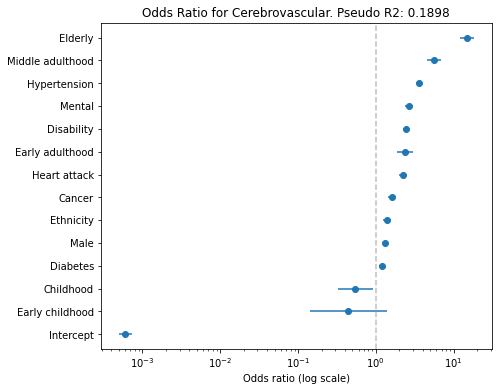

In [130]:
plot_odds( lr_best_result_brain, 'Cerebrovascular' )

### Diabetes

In [87]:
lr_best_result_diabetes = forward_selected( X, 'Diabetes' )

Training with: ['CicloVida_PrimeraInfancia']
Optimization terminated successfully.
         Current function value: 0.681204
         Iterations 10
Training with: ['Hipertension']
Optimization terminated successfully.
         Current function value: 0.668001
         Iterations 5
Training with: ['CicloVida_infancia']
Optimization terminated successfully.
         Current function value: 0.644783
         Iterations 10
Training with: ['Cerebro']
Optimization terminated successfully.
         Current function value: 0.691613
         Iterations 5
Training with: ['CicloVida_AdulteTemprana']
Optimization terminated successfully.
         Current function value: 0.544229
         Iterations 8
Training with: ['IndEtnia_Si']
Optimization terminated successfully.
         Current function value: 0.654338
         Iterations 7
Training with: ['IndDiscapacidad_Si']
Optimization terminated successfully.
         Current function value: 0.679280
         Iterations 6
Training with: ['Sexo_Masculi

In [91]:
print( lr_best_result_diabetes.summary2() )

                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.211      
Dependent Variable:    Diabetes            AIC:                 138665.4333
Date:                  2020-08-02 16:16    BIC:                 138821.2436
No. Observations:      503484              Log-Likelihood:      -69319.    
Df Model:              13                  LL-Null:             -87902.    
Df Residuals:          503470              LLR p-value:         0.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        10.0000                                             
---------------------------------------------------------------------------
                           Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                 -4.7783   0.0335 -142.7741 0.0000 -4.8439 -4.7127
Hipertension               1.8594   0.0175 

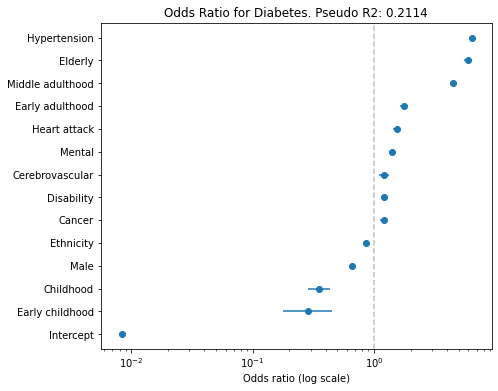

In [131]:
plot_odds( lr_best_result_diabetes, 'Diabetes' )

### Hypertension

In [72]:
lr_best_result_hipertension = forward_selected( X, 'Hipertension' )

Training with: ['CicloVida_PrimeraInfancia']
Optimization terminated successfully.
         Current function value: 0.681288
         Iterations 10
Training with: ['Diabetes']
Optimization terminated successfully.
         Current function value: 0.691551
         Iterations 4
Training with: ['CicloVida_infancia']
Optimization terminated successfully.
         Current function value: 0.644747
         Iterations 10
Training with: ['Cerebro']
Optimization terminated successfully.
         Current function value: 0.692863
         Iterations 4
Training with: ['CicloVida_AdulteTemprana']
Optimization terminated successfully.
         Current function value: 0.563950
         Iterations 7
Training with: ['IndEtnia_Si']
Optimization terminated successfully.
         Current function value: 0.670526
         Iterations 6
Training with: ['IndDiscapacidad_Si']
Optimization terminated successfully.
         Current function value: 0.690967
         Iterations 4
Training with: ['Sexo_Masculino']

In [73]:
print( lr_best_result_hipertension.summary2() )

                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.330      
Dependent Variable:    Hipertension        AIC:                 263945.1344
Date:                  2020-08-02 16:03    BIC:                 264100.9447
No. Observations:      503484              Log-Likelihood:      -1.3196e+05
Df Model:              13                  LL-Null:             -1.9700e+05
Df Residuals:          503470              LLR p-value:         0.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        10.0000                                             
---------------------------------------------------------------------------
                           Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                 -4.7666   0.0336 -141.9181 0.0000 -4.8325 -4.7008
CicloVida_AdultoMayor      4.7637   0.0347 

In [153]:
np.exp( lr_best_result_hipertension.params )

Intercept                      0.008509
CicloVida_AdultoMayor        117.180792
CicloVida_AdulteMedia         27.942859
Diabetes                       6.420792
CicloVida_AdulteTemprana       4.902242
Sexo_Masculino                 0.540132
Infarto                        5.741511
Cerebro                        3.502050
Mental                         1.520966
IndDiscapacidad_Si             1.455496
Tumor                          1.361004
CicloVida_infancia             0.357338
CicloVida_PrimeraInfancia      0.420383
IndEtnia_Si                    0.927310
dtype: float64

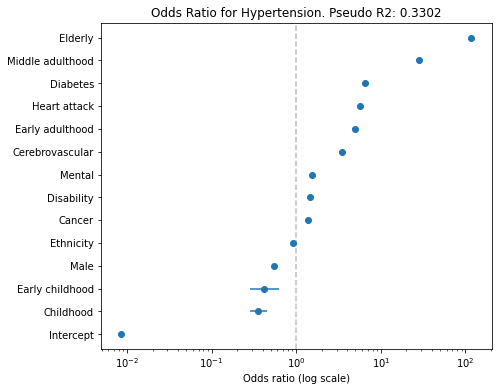

In [132]:
plot_odds( lr_best_result_hipertension, 'Hypertension' )

### Heart attack

In [94]:
lr_best_result_heart_attack = forward_selected( X, 'Infarto' )

Training with: ['CicloVida_PrimeraInfancia']
Optimization terminated successfully.
         Current function value: 0.681074
         Iterations 11
Training with: ['Diabetes']
Optimization terminated successfully.
         Current function value: 0.673489
         Iterations 7
Training with: ['Hipertension']
Optimization terminated successfully.
         Current function value: 0.631851
         Iterations 7
Training with: ['CicloVida_infancia']
Optimization terminated successfully.
         Current function value: 0.643736
         Iterations 12
Training with: ['Cerebro']
Optimization terminated successfully.
         Current function value: 0.690697
         Iterations 6
Training with: ['CicloVida_AdulteTemprana']
Optimization terminated successfully.
         Current function value: 0.529336
         Iterations 10
Training with: ['IndEtnia_Si']
Optimization terminated successfully.
         Current function value: 0.646550
         Iterations 9
Training with: ['IndDiscapacidad_Si']


In [95]:
print( lr_best_result_heart_attack.summary2() )

                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.212     
Dependent Variable:    Infarto             AIC:                 49927.8322
Date:                  2020-08-02 16:20    BIC:                 50083.6425
No. Observations:      503484              Log-Likelihood:      -24950.   
Df Model:              13                  LL-Null:             -31656.   
Df Residuals:          503470              LLR p-value:         0.0000    
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        12.0000                                            
--------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                 -7.4234   0.1020 -72.8082 0.0000 -7.6232 -7.2235
Hipertension               1.7730   0.0341  51.9200 0.0

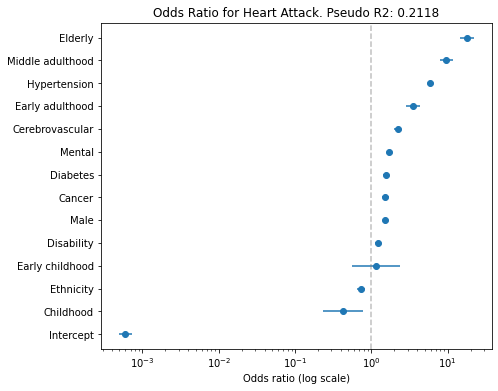

In [133]:
plot_odds( lr_best_result_heart_attack, 'Heart Attack' )

### Mental Health

In [97]:
lr_best_result_mental = forward_selected( X, 'Mental' )

Training with: ['CicloVida_PrimeraInfancia']
Optimization terminated successfully.
         Current function value: 0.683326
         Iterations 7
Training with: ['Diabetes']
Optimization terminated successfully.
         Current function value: 0.677805
         Iterations 6
Training with: ['Hipertension']
Optimization terminated successfully.
         Current function value: 0.641098
         Iterations 6
Training with: ['CicloVida_infancia']
Optimization terminated successfully.
         Current function value: 0.660480
         Iterations 7
Training with: ['Cerebro']
Optimization terminated successfully.
         Current function value: 0.691541
         Iterations 5
Training with: ['CicloVida_AdulteTemprana']
Optimization terminated successfully.
         Current function value: 0.577552
         Iterations 7
Training with: ['IndEtnia_Si']
Optimization terminated successfully.
         Current function value: 0.655543
         Iterations 7
Training with: ['IndDiscapacidad_Si']
Opt

In [98]:
print( lr_best_result_mental.summary2() )

                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.023      
Dependent Variable:    Mental              AIC:                 225917.5980
Date:                  2020-08-02 16:23    BIC:                 226073.4083
No. Observations:      503484              Log-Likelihood:      -1.1294e+05
Df Model:              13                  LL-Null:             -1.1565e+05
Df Residuals:          503470              LLR p-value:         0.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        7.0000                                              
---------------------------------------------------------------------------
                           Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                 -2.6579   0.0129 -205.8940 0.0000 -2.6832 -2.6326
IndDiscapacidad_Si         1.1601   0.0213 

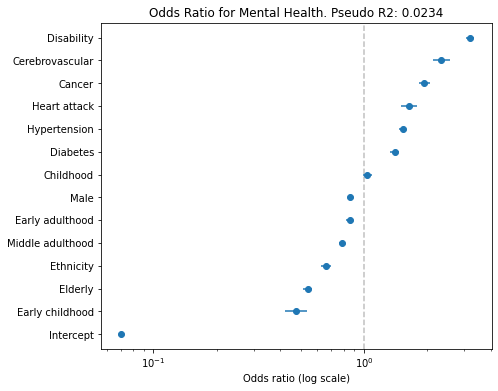

In [134]:
plot_odds( lr_best_result_mental, 'Mental Health' )

### Cancer

In [100]:
lr_best_result_cancer = forward_selected( X, 'Tumor' )

Training with: ['CicloVida_PrimeraInfancia']
Optimization terminated successfully.
         Current function value: 0.681778
         Iterations 9
Training with: ['Diabetes']
Optimization terminated successfully.
         Current function value: 0.672400
         Iterations 7
Training with: ['Hipertension']
Optimization terminated successfully.
         Current function value: 0.627810
         Iterations 7
Training with: ['CicloVida_infancia']
Optimization terminated successfully.
         Current function value: 0.646777
         Iterations 9
Training with: ['Cerebro']
Optimization terminated successfully.
         Current function value: 0.690219
         Iterations 6
Training with: ['CicloVida_AdulteTemprana']
Optimization terminated successfully.
         Current function value: 0.543165
         Iterations 8
Training with: ['IndEtnia_Si']
Optimization terminated successfully.
         Current function value: 0.649206
         Iterations 8
Training with: ['IndDiscapacidad_Si']
Opt

In [101]:
print( lr_best_result_cancer.summary2() )

                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.062     
Dependent Variable:     Tumor               AIC:                 96440.1763
Date:                   2020-08-02 16:26    BIC:                 96595.9866
No. Observations:       503484              Log-Likelihood:      -48206.   
Df Model:               13                  LL-Null:             -51392.   
Df Residuals:           503470              LLR p-value:         0.0000    
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         9.0000                                             
---------------------------------------------------------------------------
                           Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                 -4.9139   0.0357 -137.6783 0.0000 -4.9838 -4.8439
CicloVida_AdultoMayor      1.8945   0.0423 

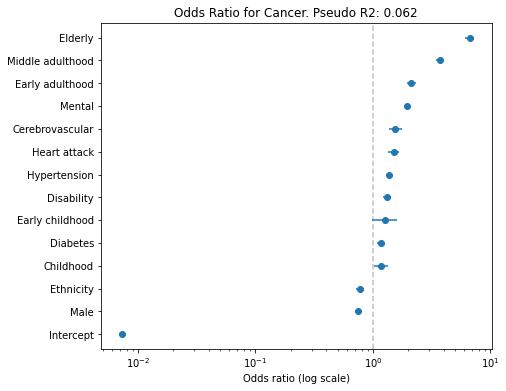

In [135]:
plot_odds( lr_best_result_cancer, 'Cancer' )

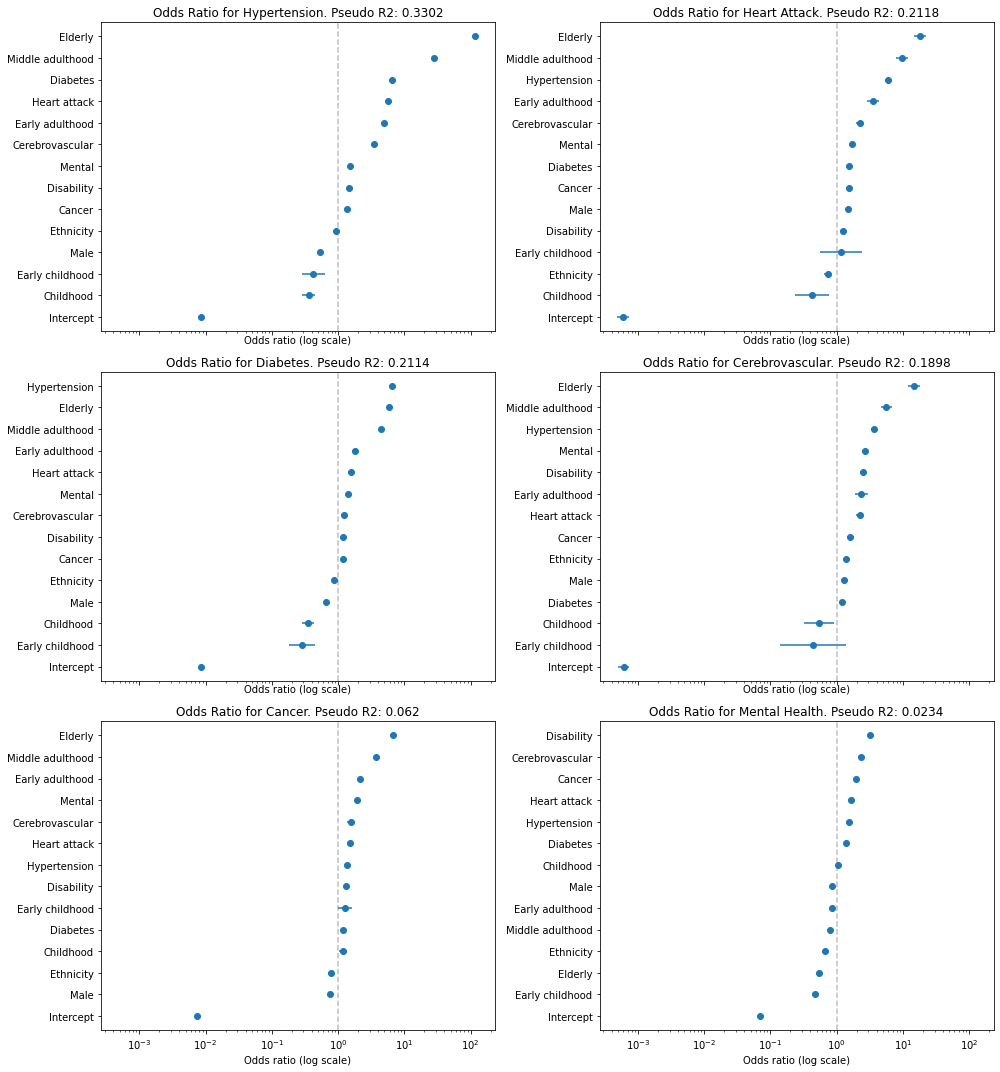

In [152]:
fig, axes = plt.subplots( nrows = 3, ncols = 2, sharex = True, figsize = ( 14, 15 ) )
ax00 = axes[ 0, 0 ]
plot_odds( lr_best_result_hipertension, 'Hypertension', ax = ax00 )
ax01 = axes[ 0, 1 ]
plot_odds( lr_best_result_heart_attack, 'Heart Attack', ax = ax01 )
ax10 = axes[ 1, 0 ]
plot_odds( lr_best_result_diabetes, 'Diabetes', ax = ax10 )
ax11 = axes[ 1, 1 ]
plot_odds( lr_best_result_brain, 'Cerebrovascular', ax = ax11 )
ax20 = axes[ 2, 0 ]
plot_odds( lr_best_result_cancer, 'Cancer', ax = ax20 )
ax21 = axes[ 2, 1 ]
plot_odds( lr_best_result_mental, 'Mental Health', ax = ax21 )
plt.tight_layout()
plt.savefig( './imgs/logreg-odds.png' )

# Training XGBoost

In [177]:
del X[ 'Intercept' ]

Cerebrovascular
0.0011309018942606728
Diabetes
0.0003772161448509996
Hypertension
0.5119290104323492
Heart attack
0.00034476814342354763
Mental
0.0016908369642973271
Cancer
0.00018875047187617969


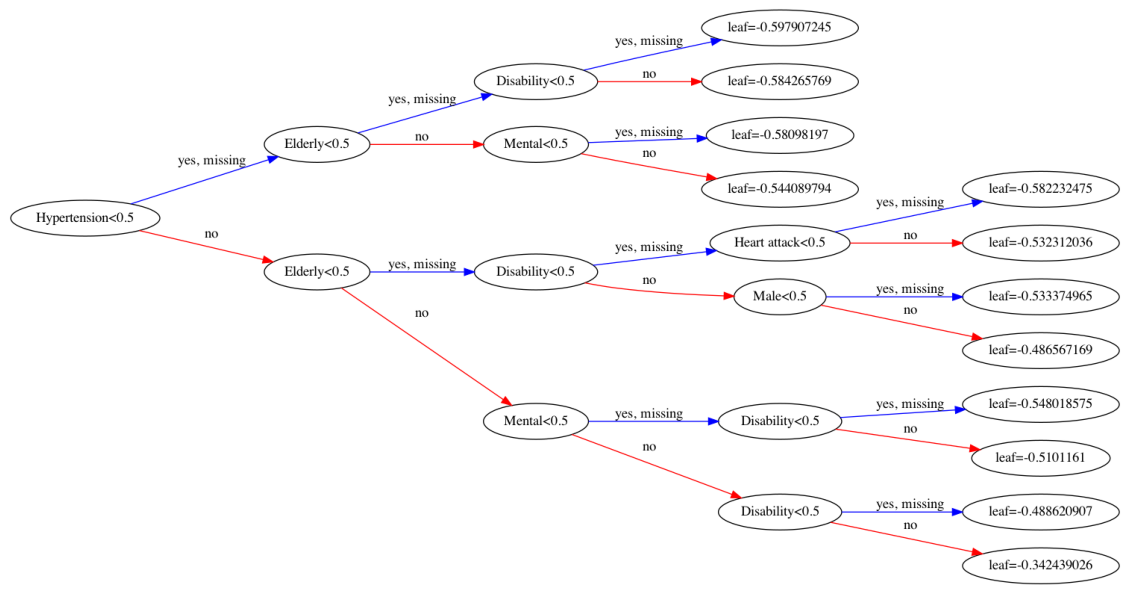

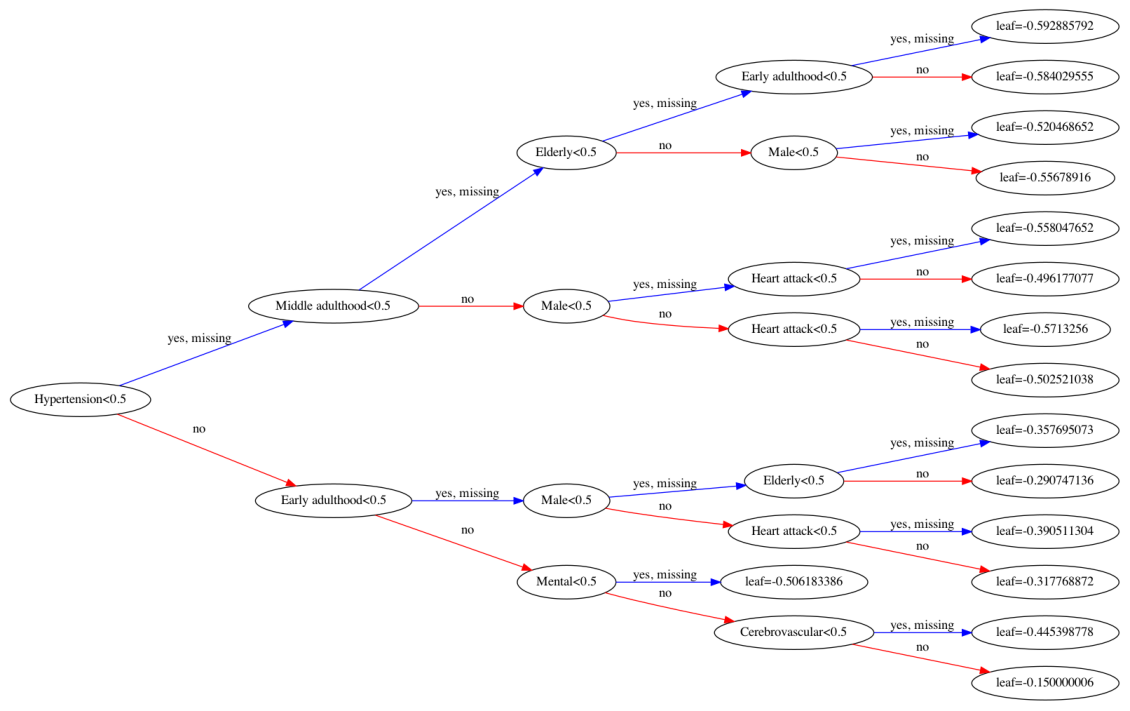

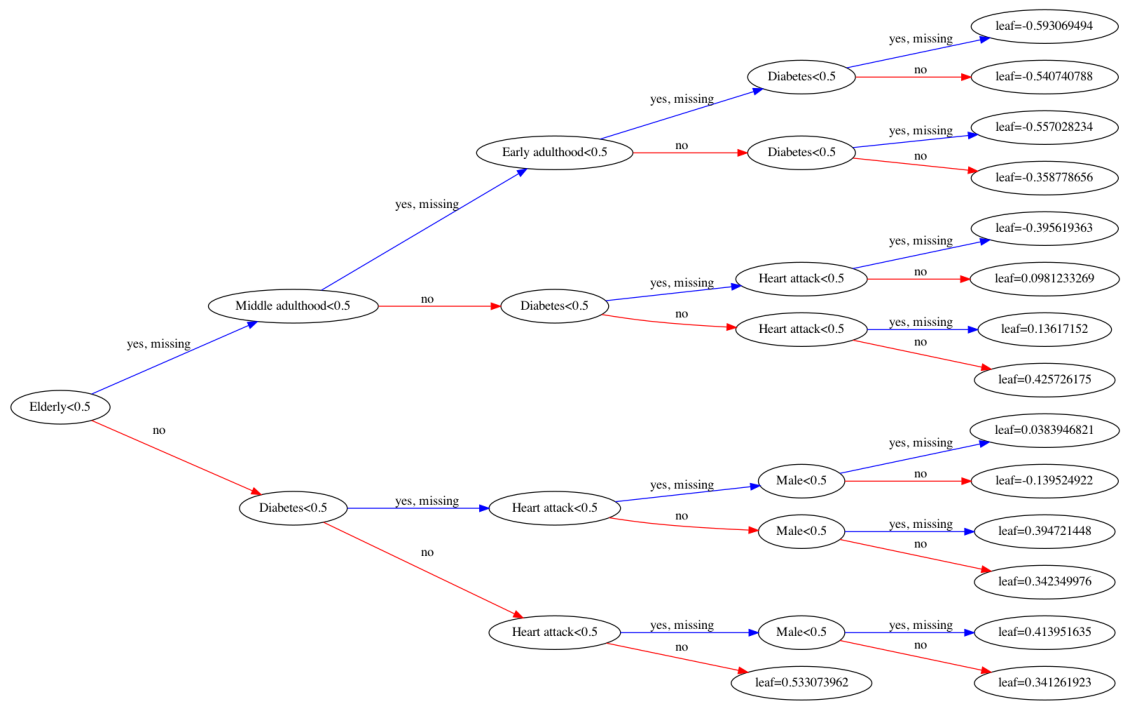

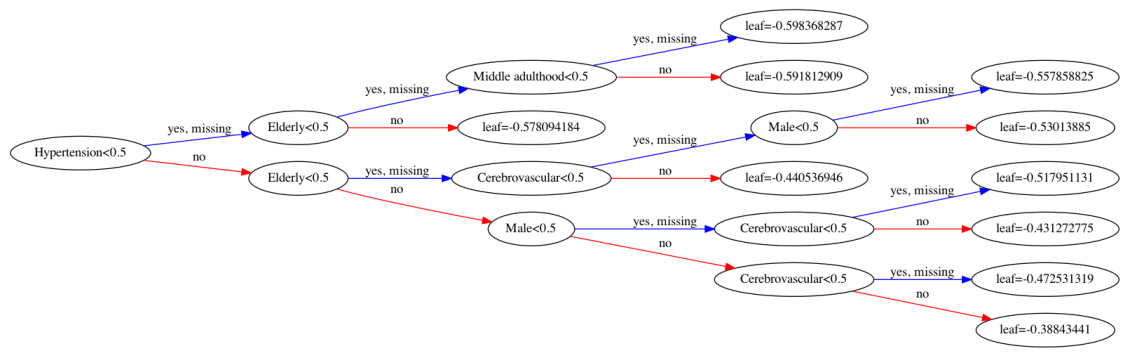

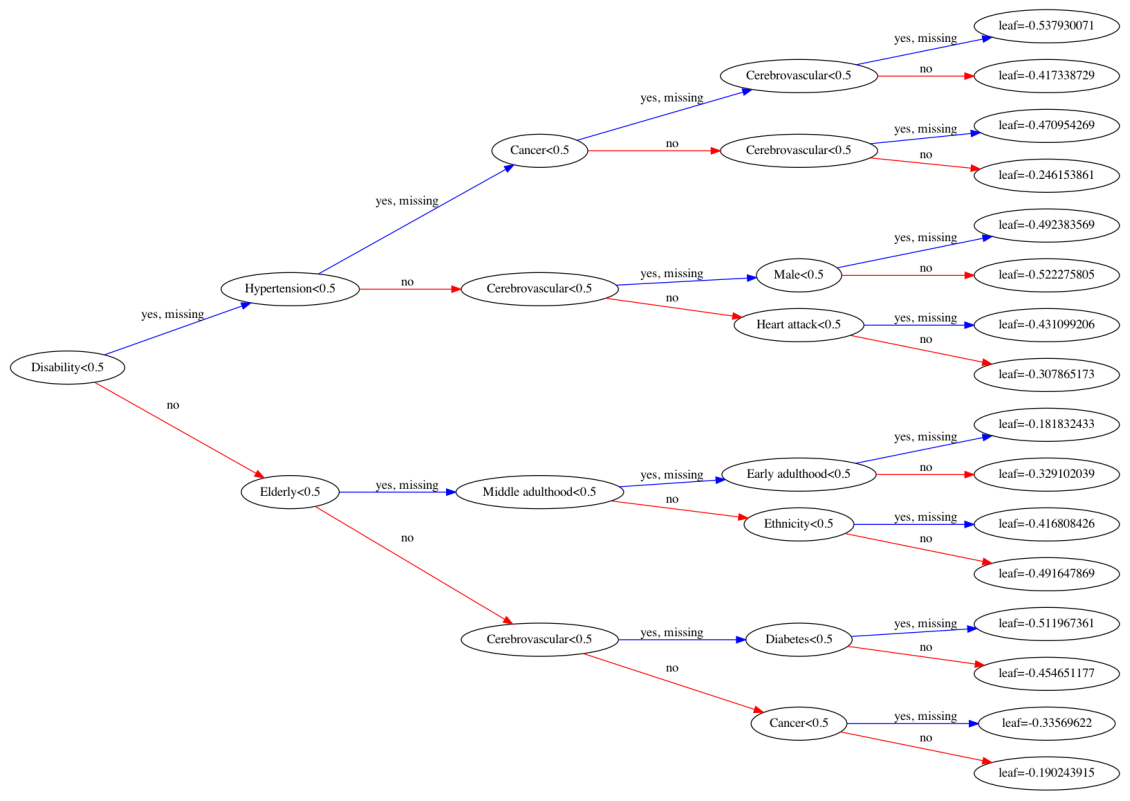

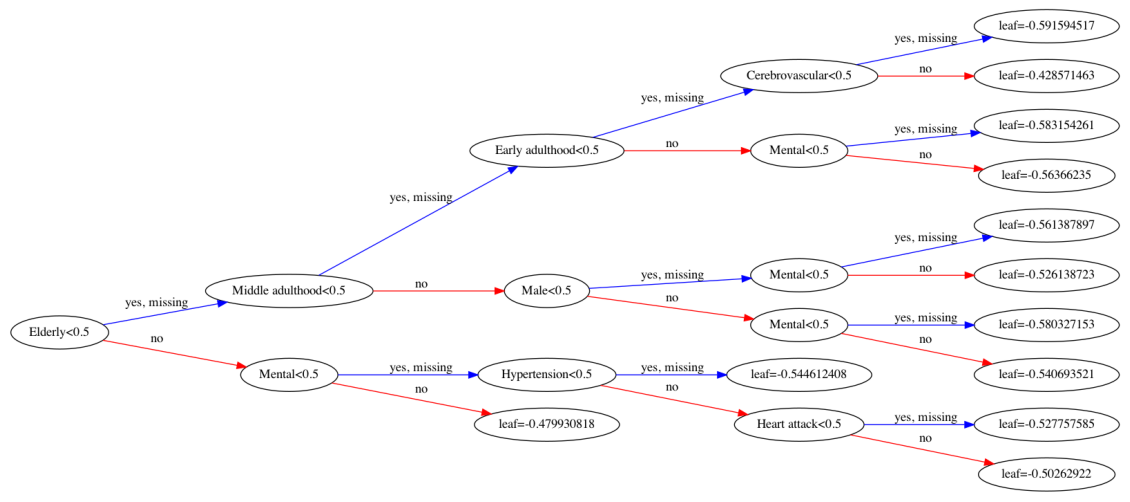

In [182]:
for disease in [ 'Cerebrovascular', 'Diabetes', 'Hypertension', 'Heart attack', 'Mental', 'Cancer' ]:
    
    X_temp = X.copy()
    del X_temp[ disease ]
    
    xgb_model = xgboost.XGBClassifier( max_depth = 4, random_state = 0 )
    xgb_model.fit( X_temp, X[ disease ] )
    
    print( disease )
    print( f1_score( X[ disease ], xgb_model.predict( X_temp ) ) )
    
    plot_tree( xgb_model, rankdir = 'LR' )
    fig = plt.gcf()
    fig.set_size_inches( 20, 20 )
    plt.savefig( './imgs/tree-{}.png'.format( disease ) )

In [189]:
xgb_model = xgboost.XGBClassifier( max_depth = 4, random_state = 0 )

#del X[ TARGET ]

xgb_model.fit( X, clean_data_df[ 'Hipertension' ] )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [190]:
f1_score( clean_data_df[ 'Hipertension' ], xgb_model.predict( X ) )

0.5119290104323492

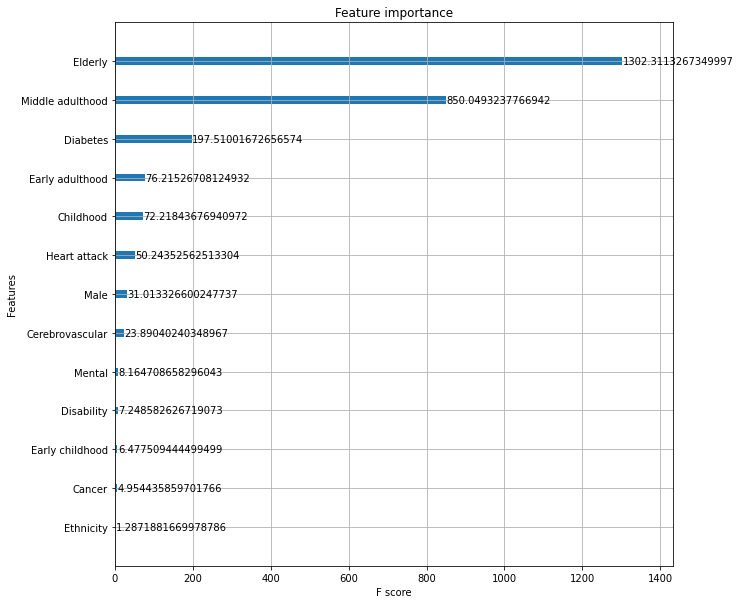

In [193]:
xgboost.plot_importance( xgb_model, importance_type = 'gain' )
fig = plt.gcf()
fig.set_size_inches( 10, 10 )

In [194]:
mybooster = xgb_model.get_booster()

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [209]:
clean_data_df[ 'Hipertension' ].loc[ ( clean_data_df[ 'Hipertension' ] == 1 ) & ( X[ 'Diabetes' ] == 1 ) ]

32        1
35        1
46        1
114       1
117       1
         ..
507577    1
514749    1
517024    1
517744    1
523608    1
Name: Hipertension, Length: 13501, dtype: int64

In [195]:
explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [215]:
shap.force_plot(explainer.expected_value, shap_values[30,:], X.iloc[30,:])

In [197]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

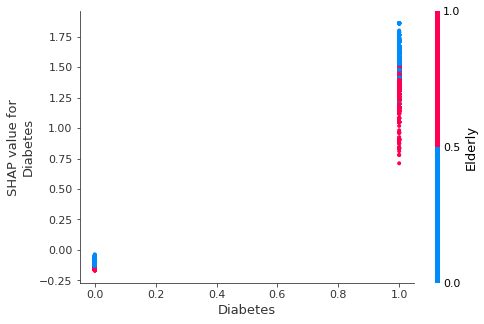

In [201]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Diabetes", shap_values, X)

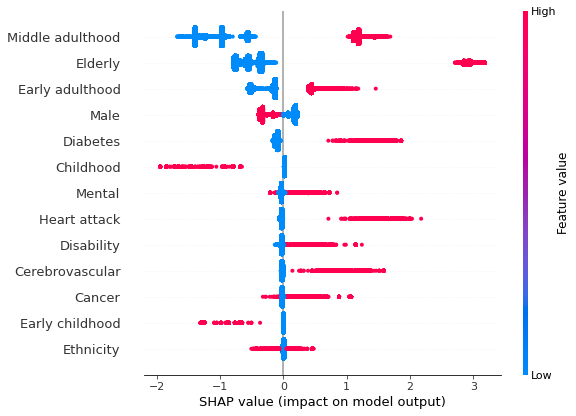

In [202]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

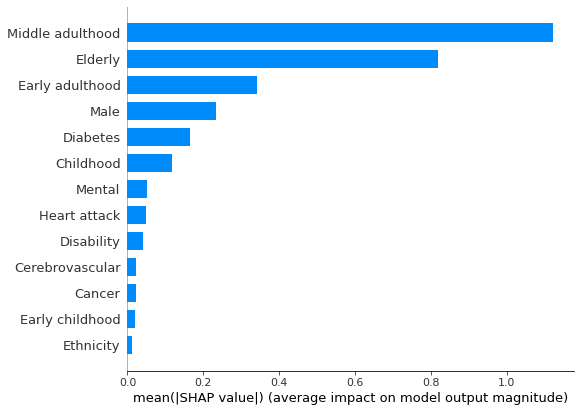

In [203]:
shap.summary_plot(shap_values, X, plot_type="bar")